## Stock Prediction using deep learning models 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, MaxPooling1D, Flatten, Conv1D
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.models import load_model
import matplotlib.pyplot as plt
import os
import joblib 


# Set output width
pd.set_option("display.width", 120)

# Data preprocessing 

# Load data
start = '2017-01-01'
end = '2023-12-31'
stock = '^NZ50'
data = yf.download(stock, start, end)
data.reset_index(inplace=True)
data['Date'] = pd.to_datetime(data['Date'])

print('Daily Dataset\n', data.head())
print('Data Types\n', data.dtypes)
print('Data Shape\n', data.shape)

# Check if there is missing values 
missing_values = data.isnull().sum()
print('Missing values:\n'), missing_values 

2024-07-01 17:22:58.631540: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[*********************100%%**********************]  1 of 1 completed

Daily Dataset
         Date         Open         High          Low        Close    Adj Close    Volume
0 2017-01-04  6881.220215  6974.310059  6881.220215  6974.310059  6974.310059  28380700
1 2017-01-05  6975.149902  6978.950195  6953.729980  6975.600098  6975.600098  21013600
2 2017-01-06  6976.200195  6986.290039  6966.020020  6970.660156  6970.660156  16967900
3 2017-01-09  6970.979980  7014.109863  6970.660156  7012.740234  7012.740234  20190700
4 2017-01-10  7012.729980  7038.629883  7011.370117  7037.580078  7037.580078  25889600
Data Types
 Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object
Data Shape
 (1751, 7)
Missing values:



(None,
 Date         0
 Open         0
 High         0
 Low          0
 Close        0
 Adj Close    0
 Volume       0
 dtype: int64)

## Plot Trading Volume

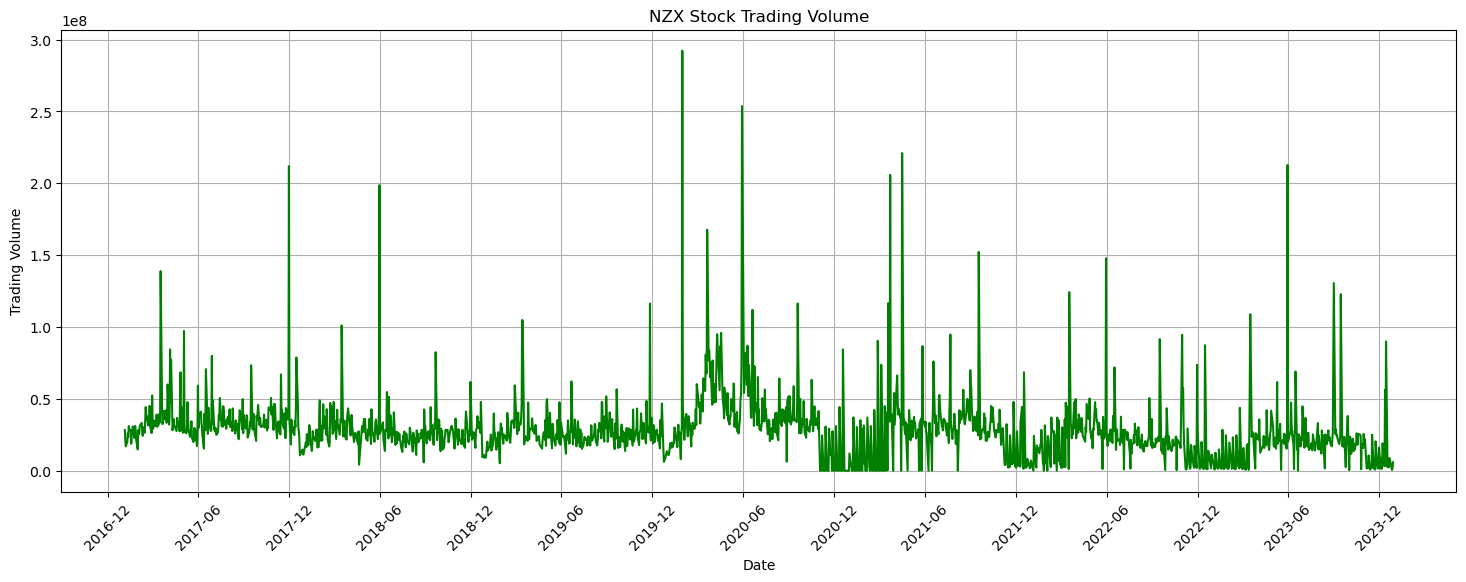

In [2]:
plt.figure(figsize=(18, 6))
plt.plot(data['Date'], data['Volume'], color="green")
plt.title("NZX Stock Trading Volume")
plt.xlabel("Date")
plt.ylabel("Trading Volume")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.xticks(rotation=45)
plt.grid()
plt.show()

## Splitting into train, validation and test sets, Data normalisation, Time sequences 

In [3]:
# Define the periods for train, validation, and test datasets
train_start_date = pd.to_datetime("2017-01-01")
train_end_date = pd.to_datetime("2021-12-31")
validate_start_date = pd.to_datetime("2022-01-01")
validate_end_date = pd.to_datetime("2022-12-31")
test_start_date = pd.to_datetime("2023-01-01")
test_end_date = pd.to_datetime("2023-12-31")

# Split data into training, validation, and testing
data_train = data[(data['Date'] >= train_start_date) & (data['Date'] <= train_end_date)]
data_validate = data[(data['Date'] >= validate_start_date) & (data['Date'] <= validate_end_date)]
data_test = data[(data['Date'] >= test_start_date) & (data['Date'] <= test_end_date)]

data_train_dates = data[(data["Date"] >= train_start_date) & (data["Date"] <= train_end_date)]["Date"]
data_validate_dates = data[(data["Date"] >= validate_start_date) & (data["Date"] <= validate_end_date)]["Date"]
data_test_dates = data[(data["Date"] >= test_start_date) & (data["Date"] <= test_end_date)]["Date"]

# Define features and target
features = ["Open", "High", "Low", "Close", "Adj Close", "Volume"]
target = "Open"

# Data scaling
scaler = MinMaxScaler(feature_range=(0, 1))
data_train_scaled = scaler.fit_transform(data_train[features])
data_validate_scaled = scaler.transform(data_validate[features])
data_test_scaled = scaler.transform(data_test[features])

# Save the scaler
scaler_model_path = "./nzx_price_scaler.pkl"
joblib.dump(scaler, scaler_model_path)


def create_sequences(data, time_steps, target):
  
    data_X = []
    data_y = []
    for i in range(time_steps, len(data)):
        data_X.append(data[i-time_steps:i,0:data.shape[1]])
        data_y.append(data[i,target])
    # Return variables
    return np.array(data_X), np.array(data_y)

# define time steps
time_steps = 60

# Combine scaled datasets all together
data_all_scaled = np.concatenate([data_train_scaled, data_validate_scaled, data_test_scaled], axis=0)

# Calculate data size
train_size = len(data_train_scaled)
validate_size = len(data_validate_scaled)
test_size = len(data_test_scaled)

X_train, y_train = create_sequences(data_train_scaled, time_steps, 0)
X_validate, y_validate = create_sequences(data_all_scaled[train_size-time_steps:train_size+validate_size,:], time_steps, 0)

X_test, y_test = create_sequences(data_all_scaled[-(test_size+time_steps):,:], time_steps, 0)

In [4]:

print(f"\n Data Train Scaled: {data_train.shape}")
print(f"> Data Train X: {X_train.shape}")
print(f"> Data Train y: {y_train.shape}")

print(f"\n Data Validate Scaled: {data_validate.shape}")
print(f"> Data Validate X: {X_validate.shape}")
print(f"> Data Validate y: {y_validate.shape}")

print(f"\n Data Test Scaled: {data_test.shape}")
print(f"> Data Test X: {X_test.shape}")
print(f"> Data Test y: {y_test.shape}")


 Data Train Scaled: (1254, 7)
> Data Train X: (1194, 60, 6)
> Data Train y: (1194,)

 Data Validate Scaled: (248, 7)
> Data Validate X: (248, 60, 6)
> Data Validate y: (248,)

 Data Test Scaled: (249, 7)
> Data Test X: (249, 60, 6)
> Data Test y: (249,)


## LSTM model 

In [5]:
# Build LSTM model
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(100, return_sequences=True),
    Dropout(0.2),
    LSTM(100, return_sequences=True),
    Dropout(0.2),
    LSTM(100, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Checkpoint to save the best model
checkpoint_path = "./best_model.keras"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1, mode='min')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, 
                    validation_data=(X_validate, y_validate), 
                    callbacks=[checkpoint], verbose=1)

# Load the best model
model = load_model(checkpoint_path)


/Users/maythutun/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.0616
Epoch 1: val_loss improved from inf to 0.00604, saving model to ./best_model.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 157ms/step - loss: 0.0606 - val_loss: 0.0060
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.0045
Epoch 2: val_loss improved from 0.00604 to 0.00194, saving model to ./best_model.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - loss: 0.0045 - val_loss: 0.0019
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.0040
Epoch 3: val_loss improved from 0.00194 to 0.00173, saving model to ./best_model.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - loss: 0.0040 - val_loss: 0.0017
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.0041
Epoch 4: val_loss did not improve from 0.00173
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - loss: 0.0041 - val_loss: 0.0053
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - loss: 0.0045
Epoch 5: val_loss did not improve from 0.00173
38/38 ━━━━━━━

38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - loss: 0.0021 - val_loss: 9.4102e-04
Epoch 32/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.0020
Epoch 32: val_loss did not improve from 0.00082
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - loss: 0.0020 - val_loss: 0.0028
Epoch 33/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.0016
Epoch 33: val_loss did not improve from 0.00082
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - loss: 0.0016 - val_loss: 0.0023
Epoch 34/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.0030
Epoch 34: val_loss did not improve from 0.00082
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 203ms/step - loss: 0.0030 - val_loss: 0.0020
Epoch 35/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.0023
Epoch 35: val_loss improved from 0.00082 to 0.00068, saving model to ./best_model.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 182ms/step - loss: 0.0023 - val_loss: 6.8216e-04
Epoch 36/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.0017
Epoch 36: val_loss did not improve from 0.000

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 100)        │        42,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 852,305 (3.25 MB)

 Trainable params: 284,101 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 568,204 (2.17 MB)

/var/folders/vh/j9ngphdx5qj9ztmhtln0kxp40000gn/T/ipykernel_22918/514620356.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'b-', label='Training loss', color='blue')
/var/folders/vh/j9ngphdx5qj9ztmhtln0kxp40000gn/T/ipykernel_22918/514620356.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'b-', label='Validation loss', color='orange')


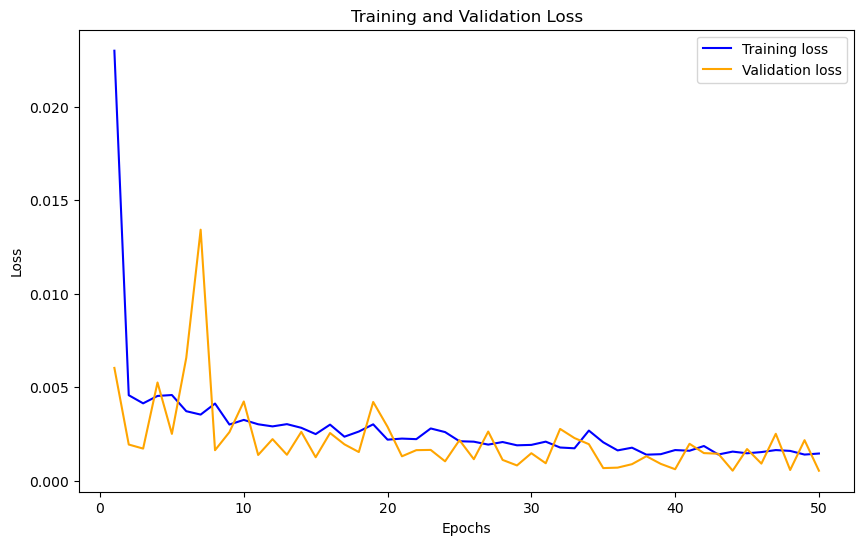

In [6]:
#model summary
model.summary()

# Plot loss curve for LSTM

# Extract the loss and val loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# Plot the training and val loss 
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'b-', label='Training loss', color='blue')  
plt.plot(epochs, val_loss, 'b-', label='Validation loss', color='orange') 
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig('loss-lstm.png')

In [7]:
# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Evaluation functions
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return rmse, r2, mape

In [8]:
# Predict stock price for all data splits
y_train_predict = model.predict(X_train)
y_validate_predict = model.predict(X_validate)
y_test_predict = model.predict(X_test)

# Restore actual distribution for predicted prices
y_train_inv = scaler.inverse_transform(np.concatenate((y_train.reshape(-1,1), np.ones((len(y_train.reshape(-1,1)), 5))), axis=1))[:,0]
y_validate_inv = scaler.inverse_transform(np.concatenate((y_validate.reshape(-1,1), np.ones((len(y_validate.reshape(-1,1)), 5))), axis=1))[:,0]
y_test_inv = scaler.inverse_transform(np.concatenate((y_test.reshape(-1,1), np.ones((len(y_test.reshape(-1,1)), 5))), axis=1))[:,0]

y_train_predict_inv = scaler.inverse_transform(np.concatenate((y_train_predict, np.ones((len(y_train_predict), 5))), axis=1))[:,0]
y_validate_predict_inv = scaler.inverse_transform(np.concatenate((y_validate_predict, np.ones((len(y_validate_predict), 5))), axis=1))[:,0]
y_test_predict_inv = scaler.inverse_transform(np.concatenate((y_test_predict, np.ones((len(y_test_predict), 5))), axis=1))[:,0]


# Calculate metrics
rmse_train, r2_train, mape_train = evaluate_model(y_train_inv, y_train_predict_inv)
rmse_validate, r2_validate, mape_validate = evaluate_model(y_validate_inv, y_validate_predict_inv)
rmse_test, r2_test, mape_test = evaluate_model(y_test_inv, y_test_predict_inv)

# Print the results
print("Training Metrics:")
print(f"RMSE: {rmse_train}, R2: {r2_train}, MAPE: {mape_train}%")

print("Validation Metrics:")
print(f"RMSE: {rmse_validate}, R2: {r2_validate}, MAPE: {mape_validate}%")

print("Testing Metrics:")
print(f"RMSE: {rmse_test}, R2: {r2_test}, MAPE: {mape_test}%")

38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Training Metrics:
RMSE: 174.17775804969375, R2: 0.9913251219744995, MAPE: 1.2254292314423803%
Validation Metrics:
RMSE: 153.74820417727528, R2: 0.9102455461544381, MAPE: 1.0745314962719692%
Testing Metrics:
RMSE: 131.09005946495455, R2: 0.8307611811314151, MAPE: 0.9595351902873389%


In [9]:
# Define chart colors
train_actual_color = "cornflowerblue"
validate_actual_color = "orange"
test_actual_color = "green"
train_predicted_color = "lightblue"
validate_predicted_color = "peru"
test_predicted_color = "limegreen"

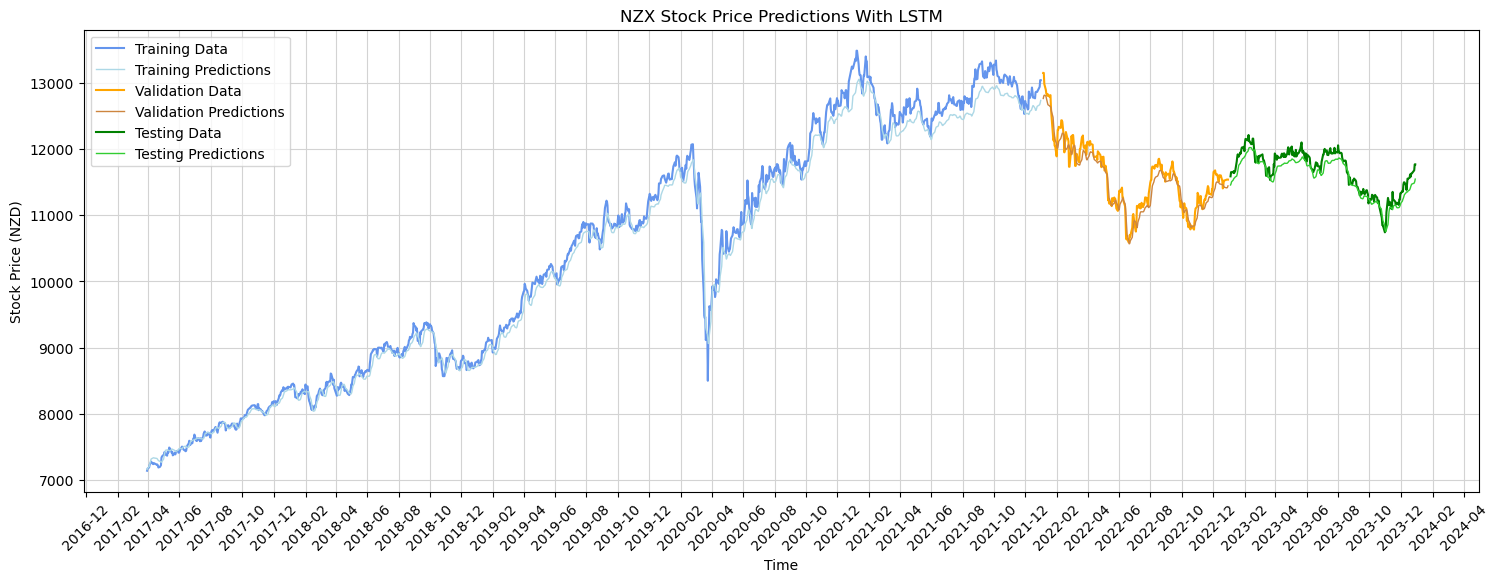

In [10]:
# Plot actual and predicted price
plt.figure(figsize=(18,6))
plt.plot(data_train_dates[time_steps:,], y_train_inv, label="Training Data", color=train_actual_color)
plt.plot(data_train_dates[time_steps:,], y_train_predict_inv, label="Training Predictions", linewidth=1, color=train_predicted_color)

plt.plot(data_validate_dates, y_validate_inv, label="Validation Data", color=validate_actual_color)
plt.plot(data_validate_dates, y_validate_predict_inv, label="Validation Predictions", linewidth=1, color=validate_predicted_color)

plt.plot(data_test_dates, y_test_inv, label="Testing Data", color=test_actual_color)
plt.plot(data_test_dates, y_test_predict_inv, label="Testing Predictions", linewidth=1, color=test_predicted_color)

plt.title("NZX Stock Price Predictions With LSTM")
plt.xlabel("Time")
plt.ylabel("Stock Price (NZD)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks(rotation=45)
plt.legend()
plt.grid(color="lightgray")
plt.savefig('nzx-lstm.png')

## GRU model

In [11]:
# Build GRU model 

GRU_model = Sequential([
    GRU(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    GRU(100, return_sequences=True),
    Dropout(0.2),
    GRU(100, return_sequences=False),
    Dropout(0.2),
    Dense(50),
    Dense(1)
])

GRU_model.compile(optimizer='adam', loss='mean_squared_error')

# Checkpoint to save the best model
checkpoint_path = "./best_model.keras"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1, mode='min')

# Train the model
gru_history = GRU_model.fit(X_train, y_train, epochs=50, batch_size=32, 
                    validation_data=(X_validate, y_validate), 
                    callbacks=[checkpoint], verbose=1)

# Load the best model
GRU_model = load_model(checkpoint_path)

Epoch 1/50


/Users/maythutun/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0592
Epoch 1: val_loss improved from inf to 0.00224, saving model to ./best_model.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - loss: 0.0583 - val_loss: 0.0022
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0048
Epoch 2: val_loss improved from 0.00224 to 0.00054, saving model to ./best_model.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 0.0048 - val_loss: 5.4457e-04
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0032
Epoch 3: val_loss improved from 0.00054 to 0.00051, saving model to ./best_model.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - loss: 0.0032 - val_loss: 5.0824e-04
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.0029
Epoch 4: val_loss did not improve from 0.00051
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - loss: 0.0029 - val_loss: 0.0012
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.0025
Epoch 5: val_loss improved from 0.00051 to 0.00050, saving model to ./be

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 9.6275e-04
Epoch 31: val_loss did not improve from 0.00034
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - loss: 9.6014e-04 - val_loss: 3.9116e-04
Epoch 32/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 6.9409e-04
Epoch 32: val_loss improved from 0.00034 to 0.00031, saving model to ./best_model.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 6.9507e-04 - val_loss: 3.0917e-04
Epoch 33/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 6.6055e-04
Epoch 33: val_loss improved from 0.00031 to 0.00030, saving model to ./best_model.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 6.6130e-04 - val_loss: 2.9829e-04
Epoch 34/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 8.0379e-04
Epoch 34: val_loss improved from 0.00030 to 0.00030, saving model to ./best_model.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - loss: 8.0268e-04 - val_loss: 2.9700e-04
Epoch 35/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 7.7285e-04
Epoch 35: val_lo

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 60, 100)        │        32,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 60, 100)        │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 100)            │        60,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 476,105 (1.82 MB)

 Trainable params: 158,701 (619.93 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 317,404 (1.21 MB)

/var/folders/vh/j9ngphdx5qj9ztmhtln0kxp40000gn/T/ipykernel_22918/4230568920.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'b-', label='Training loss', color='blue')
/var/folders/vh/j9ngphdx5qj9ztmhtln0kxp40000gn/T/ipykernel_22918/4230568920.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'b-', label='Validation loss', color='orange')


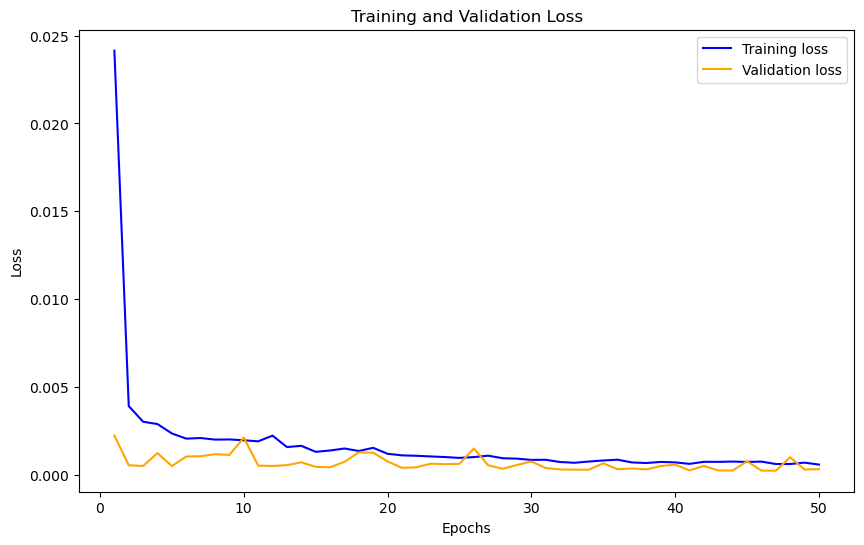

In [12]:
#model summary
GRU_model.summary()

# Plot loss curve for GRU

# Extract the loss and val loss
loss = gru_history.history['loss']
val_loss = gru_history.history['val_loss']
epochs = range(1, len(loss) + 1)

# Plot the training and val loss 
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'b-', label='Training loss', color='blue')  
plt.plot(epochs, val_loss, 'b-', label='Validation loss', color='orange') 
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig('loss-gru.png')

In [13]:
# Predict stock price for all data splits
y_train_predict = GRU_model.predict(X_train)
y_validate_predict = GRU_model.predict(X_validate)
y_test_predict = GRU_model.predict(X_test)

# Restore actual distribution for predicted prices
y_train_inv = scaler.inverse_transform(np.concatenate((y_train.reshape(-1,1), np.ones((len(y_train.reshape(-1,1)), 5))), axis=1))[:,0]
y_validate_inv = scaler.inverse_transform(np.concatenate((y_validate.reshape(-1,1), np.ones((len(y_validate.reshape(-1,1)), 5))), axis=1))[:,0]
y_test_inv = scaler.inverse_transform(np.concatenate((y_test.reshape(-1,1), np.ones((len(y_test.reshape(-1,1)), 5))), axis=1))[:,0]

y_train_predict_inv = scaler.inverse_transform(np.concatenate((y_train_predict, np.ones((len(y_train_predict), 5))), axis=1))[:,0]
y_validate_predict_inv = scaler.inverse_transform(np.concatenate((y_validate_predict, np.ones((len(y_validate_predict), 5))), axis=1))[:,0]
y_test_predict_inv = scaler.inverse_transform(np.concatenate((y_test_predict, np.ones((len(y_test_predict), 5))), axis=1))[:,0]

# Calculate metrics
rmse_train, r2_train, mape_train = evaluate_model(y_train_inv, y_train_predict_inv)
rmse_validate, r2_validate, mape_validate = evaluate_model(y_validate_inv, y_validate_predict_inv)
rmse_test, r2_test, mape_test = evaluate_model(y_test_inv, y_test_predict_inv)

# Print the results
print("Training Metrics:")
print(f"RMSE: {rmse_train}, R2: {r2_train}, MAPE: {mape_train}%")

print("Validation Metrics:")
print(f"RMSE: {rmse_validate}, R2: {r2_validate}, MAPE: {mape_validate}%")

print("Testing Metrics:")
print(f"RMSE: {rmse_test}, R2: {r2_test}, MAPE: {mape_test}%")


38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Training Metrics:
RMSE: 86.04758016122638, R2: 0.9978828320653352, MAPE: 0.6523904585270652%
Validation Metrics:
RMSE: 101.747316185857, R2: 0.9606919201039709, MAPE: 0.6537837313858228%
Testing Metrics:
RMSE: 62.672359905406644, R2: 0.9613176757367122, MAPE: 0.4062946196422108%


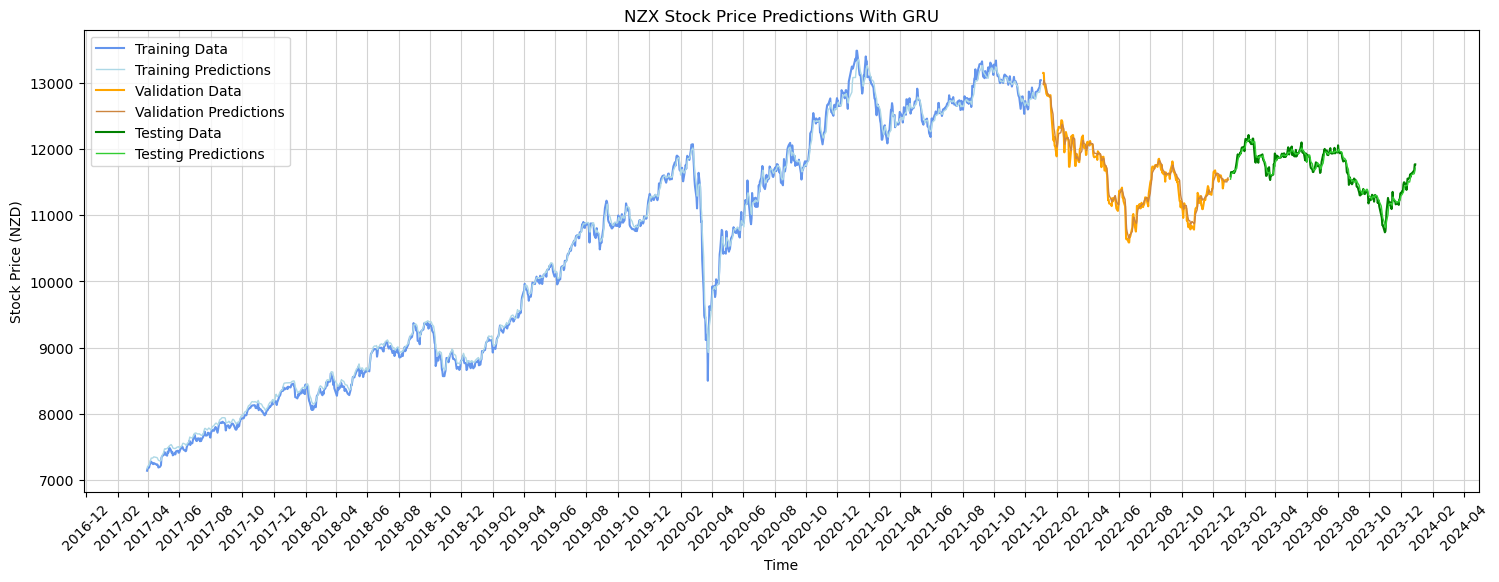

In [14]:
# Plot actual and predicted price
plt.figure(figsize=(18,6))
plt.plot(data_train_dates[time_steps:,], y_train_inv, label="Training Data", color=train_actual_color)
plt.plot(data_train_dates[time_steps:,], y_train_predict_inv, label="Training Predictions", linewidth=1, color=train_predicted_color)

plt.plot(data_validate_dates, y_validate_inv, label="Validation Data", color=validate_actual_color)
plt.plot(data_validate_dates, y_validate_predict_inv, label="Validation Predictions", linewidth=1, color=validate_predicted_color)

plt.plot(data_test_dates, y_test_inv, label="Testing Data", color=test_actual_color)
plt.plot(data_test_dates, y_test_predict_inv, label="Testing Predictions", linewidth=1, color=test_predicted_color)

plt.title("NZX Stock Price Predictions With GRU")
plt.xlabel("Time")
plt.ylabel("Stock Price (NZD)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks(rotation=45)
plt.legend()
plt.grid(color="lightgray")
plt.savefig('nzx-gru.png')

## CNN model 

In [15]:
# Build CNN model 

CNN_model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Conv1D(128,2, activation='tanh'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dense(1)
])

CNN_model.compile(optimizer='adam', loss='mean_squared_error')

# Checkpoint to save the best model
checkpoint_path = "./best_model.keras"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1, mode='min')

# Train the model
CNN_history = CNN_model.fit(X_train, y_train, epochs=50, batch_size=32, 
                    validation_data=(X_validate, y_validate), 
                    callbacks=[checkpoint], verbose=1)

# Load the best model
CNN_model = load_model(checkpoint_path)

Epoch 1/50


/Users/maythutun/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1181
Epoch 1: val_loss improved from inf to 0.00465, saving model to ./best_model.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0978 - val_loss: 0.0047
Epoch 2/50
32/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0048
Epoch 2: val_loss improved from 0.00465 to 0.00286, saving model to ./best_model.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0047 - val_loss: 0.0029
Epoch 3/50
29/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044
Epoch 3: val_loss improved from 0.00286 to 0.00261, saving model to ./best_model.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0043 - val_loss: 0.0026
Epoch 4/50
36/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0034
Epoch 4: val_loss improved from 0.00261 to 0.00178, saving model to ./best_model.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0033 - val_loss: 0.0018
Epoch 5/50
33/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0027
Epoch 5: val_loss did not improve from 0.00178
3

Epoch 31/50
31/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.1234e-04
Epoch 31: val_loss improved from 0.00083 to 0.00079, saving model to ./best_model.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.0324e-04 - val_loss: 7.9244e-04
Epoch 32/50
30/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.6434e-04
Epoch 32: val_loss did not improve from 0.00079
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.6176e-04 - val_loss: 0.0011
Epoch 33/50
31/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0013   
Epoch 33: val_loss did not improve from 0.00079
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013 - val_loss: 9.8434e-04
Epoch 34/50
35/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.8674e-04
Epoch 34: val_loss improved from 0.00079 to 0.00079, saving model to ./best_model.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.8630e-04 - val_loss: 7.8713e-04
Epoch 35/50
30/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.5824e-04
Epoch 35: val_loss did not improve from 0.00079
38/38 ━━━━━━━━━

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 59, 64)         │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 29, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 28, 128)        │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 14, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1792)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1792)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 50)             │        89,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 321,137 (1.23 MB)

 Trainable params: 107,045 (418.14 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 214,092 (836.30 KB)

/var/folders/vh/j9ngphdx5qj9ztmhtln0kxp40000gn/T/ipykernel_22918/1729037764.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'b-', label='Training loss', color='blue')
/var/folders/vh/j9ngphdx5qj9ztmhtln0kxp40000gn/T/ipykernel_22918/1729037764.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'b-', label='Validation loss', color='orange')


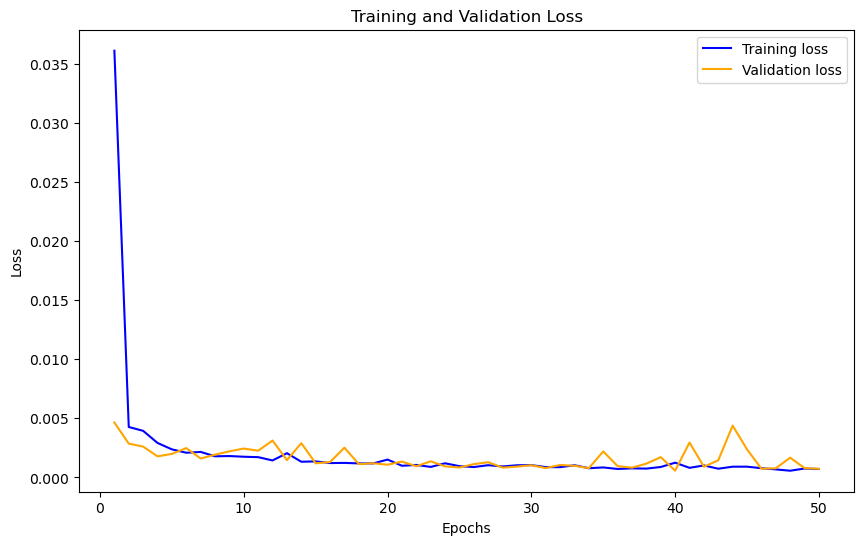

In [16]:
#model summary
CNN_model.summary()

# Plot loss curve for CNN

# Extract the loss and val loss
loss = CNN_history.history['loss']
val_loss = CNN_history.history['val_loss']
epochs = range(1, len(loss) + 1)

# Plot the training and val loss 
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'b-', label='Training loss', color='blue')  
plt.plot(epochs, val_loss, 'b-', label='Validation loss', color='orange') 
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig('loss-cnn.png')

In [17]:
# Predict stock price for all data splits
y_train_predict = CNN_model.predict(X_train)
y_validate_predict = CNN_model.predict(X_validate)
y_test_predict = CNN_model.predict(X_test)

# Restore actual distribution for predicted prices
y_train_inv = scaler.inverse_transform(np.concatenate((y_train.reshape(-1,1), np.ones((len(y_train.reshape(-1,1)), 5))), axis=1))[:,0]
y_validate_inv = scaler.inverse_transform(np.concatenate((y_validate.reshape(-1,1), np.ones((len(y_validate.reshape(-1,1)), 5))), axis=1))[:,0]
y_test_inv = scaler.inverse_transform(np.concatenate((y_test.reshape(-1,1), np.ones((len(y_test.reshape(-1,1)), 5))), axis=1))[:,0]

y_train_predict_inv = scaler.inverse_transform(np.concatenate((y_train_predict, np.ones((len(y_train_predict), 5))), axis=1))[:,0]
y_validate_predict_inv = scaler.inverse_transform(np.concatenate((y_validate_predict, np.ones((len(y_validate_predict), 5))), axis=1))[:,0]
y_test_predict_inv = scaler.inverse_transform(np.concatenate((y_test_predict, np.ones((len(y_test_predict), 5))), axis=1))[:,0]

# Calculate metrics
rmse_train, r2_train, mape_train = evaluate_model(y_train_inv, y_train_predict_inv)
rmse_validate, r2_validate, mape_validate = evaluate_model(y_validate_inv, y_validate_predict_inv)
rmse_test, r2_test, mape_test = evaluate_model(y_test_inv, y_test_predict_inv)

# Print the results
print("Training Metrics:")
print(f"RMSE: {rmse_train}, R2: {r2_train}, MAPE: {mape_train}%")

print("Validation Metrics:")
print(f"RMSE: {rmse_validate}, R2: {r2_validate}, MAPE: {mape_validate}%")

print("Testing Metrics:")
print(f"RMSE: {rmse_test}, R2: {r2_test}, MAPE: {mape_test}%")

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Training Metrics:
RMSE: 143.18700820408867, R2: 0.9941374681594548, MAPE: 1.0075969675139276%
Validation Metrics:
RMSE: 158.28538965720477, R2: 0.9048699851889178, MAPE: 1.0749218315285758%
Testing Metrics:
RMSE: 134.6095801117422, R2: 0.8215517045615748, MAPE: 0.909048673831905%


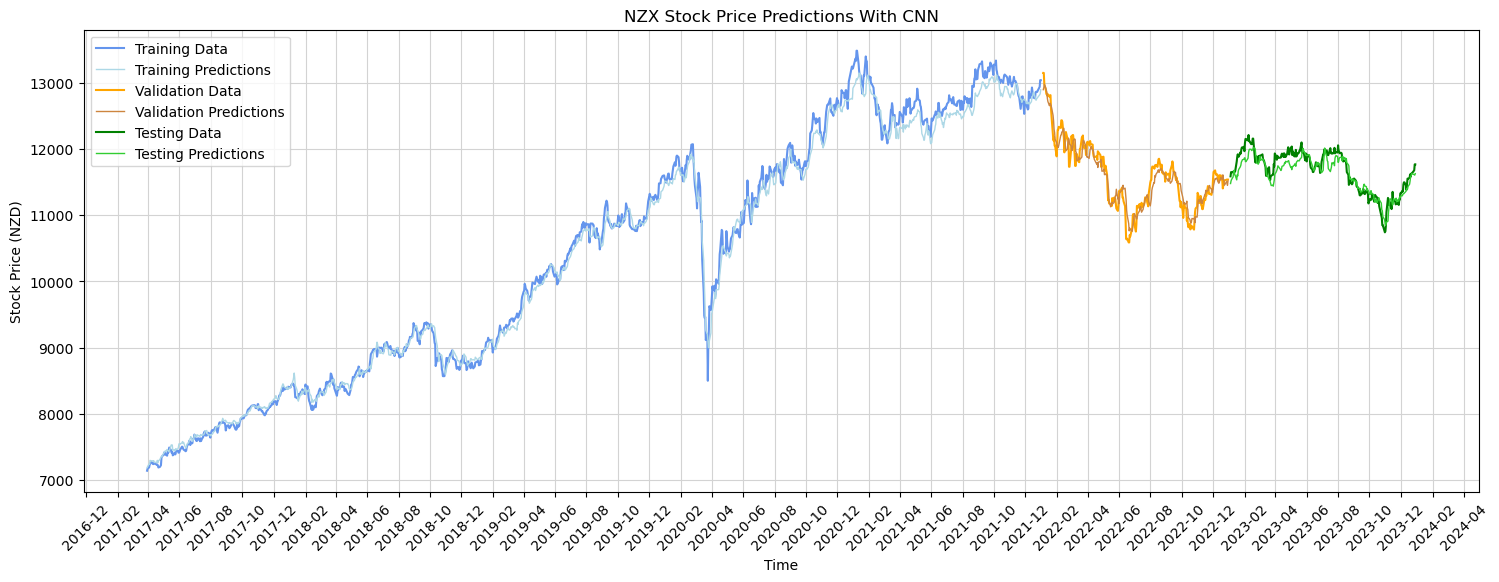

In [18]:
# Plot actual and predicted price
plt.figure(figsize=(18,6))
plt.plot(data_train_dates[time_steps:,], y_train_inv, label="Training Data", color=train_actual_color)
plt.plot(data_train_dates[time_steps:,], y_train_predict_inv, label="Training Predictions", linewidth=1, color=train_predicted_color)

plt.plot(data_validate_dates, y_validate_inv, label="Validation Data", color=validate_actual_color)
plt.plot(data_validate_dates, y_validate_predict_inv, label="Validation Predictions", linewidth=1, color=validate_predicted_color)

plt.plot(data_test_dates, y_test_inv, label="Testing Data", color=test_actual_color)
plt.plot(data_test_dates, y_test_predict_inv, label="Testing Predictions", linewidth=1, color=test_predicted_color)

plt.title("NZX Stock Price Predictions With CNN")
plt.xlabel("Time")
plt.ylabel("Stock Price (NZD)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks(rotation=45)
plt.legend()
plt.grid(color="lightgray")
plt.savefig('nzx-cnn.png')

## CNN-LSTM model

In [19]:
# Build CNN-LSTM model 
# model architecture from https://doi.org/10.1155/2020/6622927

CNN_LSTM_model = Sequential([
    Conv1D(filters=128, kernel_size=2, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Conv1D(128,2, activation='tanh'),
    MaxPooling1D(pool_size=2),
    LSTM(128),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dense(1)
])

CNN_LSTM_model.compile(optimizer='adam', loss='mean_squared_error')

# Checkpoint to save the best model
checkpoint_path = "./best_model.keras"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1, mode='min')

# Train the model
CNN_LSTM_history = CNN_LSTM_model.fit(X_train, y_train, epochs=50, batch_size=32, 
                    validation_data=(X_validate, y_validate), 
                    callbacks=[checkpoint], verbose=1)

# Load the best model
CNN_LSTM_model = load_model(checkpoint_path)


/Users/maythutun/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
36/38 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0591
Epoch 1: val_loss improved from inf to 0.00199, saving model to ./best_model.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0563 - val_loss: 0.0020
Epoch 2/50
35/38 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0041
Epoch 2: val_loss improved from 0.00199 to 0.00155, saving model to ./best_model.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0041 - val_loss: 0.0015
Epoch 3/50
35/38 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0040
Epoch 3: val_loss did not improve from 0.00155
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0040 - val_loss: 0.0019
Epoch 4/50
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0026
Epoch 4: val_loss did not improve from 0.00155
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0026 - val_loss: 0.0021
Epoch 5/50
35/38 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0028
Epoch 5: val_loss did not improve from 0.00155
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0028 - val_lo

Epoch 32/50
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0011
Epoch 32: val_loss improved from 0.00067 to 0.00059, saving model to ./best_model.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0011 - val_loss: 5.8712e-04
Epoch 33/50
36/38 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 9.6707e-04
Epoch 33: val_loss did not improve from 0.00059
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 9.6647e-04 - val_loss: 6.9866e-04
Epoch 34/50
36/38 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 9.1862e-04
Epoch 34: val_loss did not improve from 0.00059
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 9.1579e-04 - val_loss: 0.0019
Epoch 35/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0011
Epoch 35: val_loss did not improve from 0.00059
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0011 - val_loss: 8.4600e-04
Epoch 36/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0013
Epoch 36: val_loss did not improve from 0.00059
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0013 - val_

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 59, 128)        │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 29, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 28, 128)        │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 14, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 50)             │         6,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 517,937 (1.98 MB)

 Trainable params: 172,645 (674.39 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 345,292 (1.32 MB)

/var/folders/vh/j9ngphdx5qj9ztmhtln0kxp40000gn/T/ipykernel_22918/813447700.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'b-', label='Training loss', color='blue')
/var/folders/vh/j9ngphdx5qj9ztmhtln0kxp40000gn/T/ipykernel_22918/813447700.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'b-', label='Validation loss', color='orange')


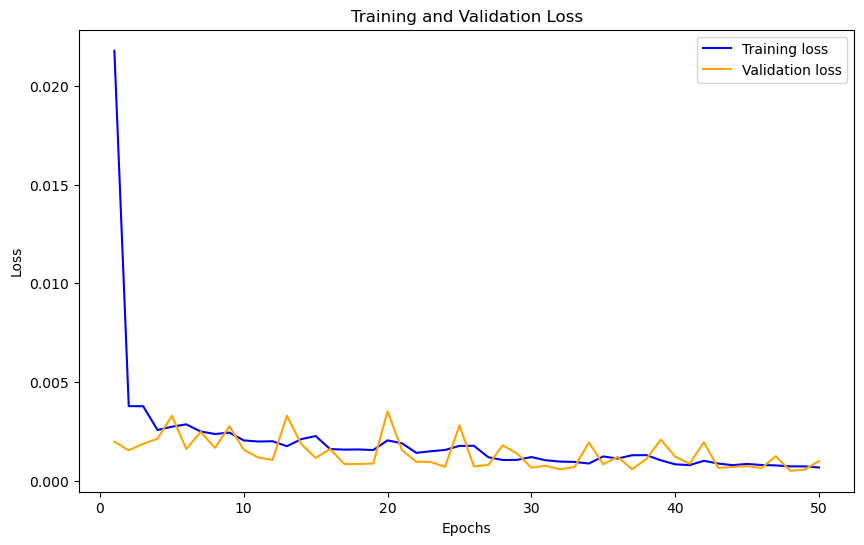

In [20]:
#model summary
CNN_LSTM_model.summary()

# Plot loss curve for CNN

# Extract the loss and val loss
loss = CNN_LSTM_history.history['loss']
val_loss = CNN_LSTM_history.history['val_loss']
epochs = range(1, len(loss) + 1)

# Plot the training and val loss 
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'b-', label='Training loss', color='blue')  
plt.plot(epochs, val_loss, 'b-', label='Validation loss', color='orange') 
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig('loss-cnnlstm.png')

In [21]:
# Predict stock price for all data splits
y_train_predict = CNN_LSTM_model.predict(X_train)
y_validate_predict = CNN_LSTM_model.predict(X_validate)
y_test_predict = CNN_LSTM_model.predict(X_test)

# Restore actual distribution for predicted prices
y_train_inv = scaler.inverse_transform(np.concatenate((y_train.reshape(-1,1), np.ones((len(y_train.reshape(-1,1)), 5))), axis=1))[:,0]
y_validate_inv = scaler.inverse_transform(np.concatenate((y_validate.reshape(-1,1), np.ones((len(y_validate.reshape(-1,1)), 5))), axis=1))[:,0]
y_test_inv = scaler.inverse_transform(np.concatenate((y_test.reshape(-1,1), np.ones((len(y_test.reshape(-1,1)), 5))), axis=1))[:,0]

y_train_predict_inv = scaler.inverse_transform(np.concatenate((y_train_predict, np.ones((len(y_train_predict), 5))), axis=1))[:,0]
y_validate_predict_inv = scaler.inverse_transform(np.concatenate((y_validate_predict, np.ones((len(y_validate_predict), 5))), axis=1))[:,0]
y_test_predict_inv = scaler.inverse_transform(np.concatenate((y_test_predict, np.ones((len(y_test_predict), 5))), axis=1))[:,0]

# Calculate metrics
rmse_train, r2_train, mape_train = evaluate_model(y_train_inv, y_train_predict_inv)
rmse_validate, r2_validate, mape_validate = evaluate_model(y_validate_inv, y_validate_predict_inv)
rmse_test, r2_test, mape_test = evaluate_model(y_test_inv, y_test_predict_inv)

# Print the results
print("Training Metrics:")
print(f"RMSE: {rmse_train}, R2: {r2_train}, MAPE: {mape_train}%")

print("Validation Metrics:")
print(f"RMSE: {rmse_validate}, R2: {r2_validate}, MAPE: {mape_validate}%")

print("Testing Metrics:")
print(f"RMSE: {rmse_test}, R2: {r2_test}, MAPE: {mape_test}%")

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Training Metrics:
RMSE: 141.43388434496472, R2: 0.9942801462738738, MAPE: 0.9518911117419466%
Validation Metrics:
RMSE: 150.05685379316066, R2: 0.9145036492829255, MAPE: 0.9729534475663261%
Testing Metrics:
RMSE: 94.87444314426051, R2: 0.9113540406378579, MAPE: 0.6251316906020816%


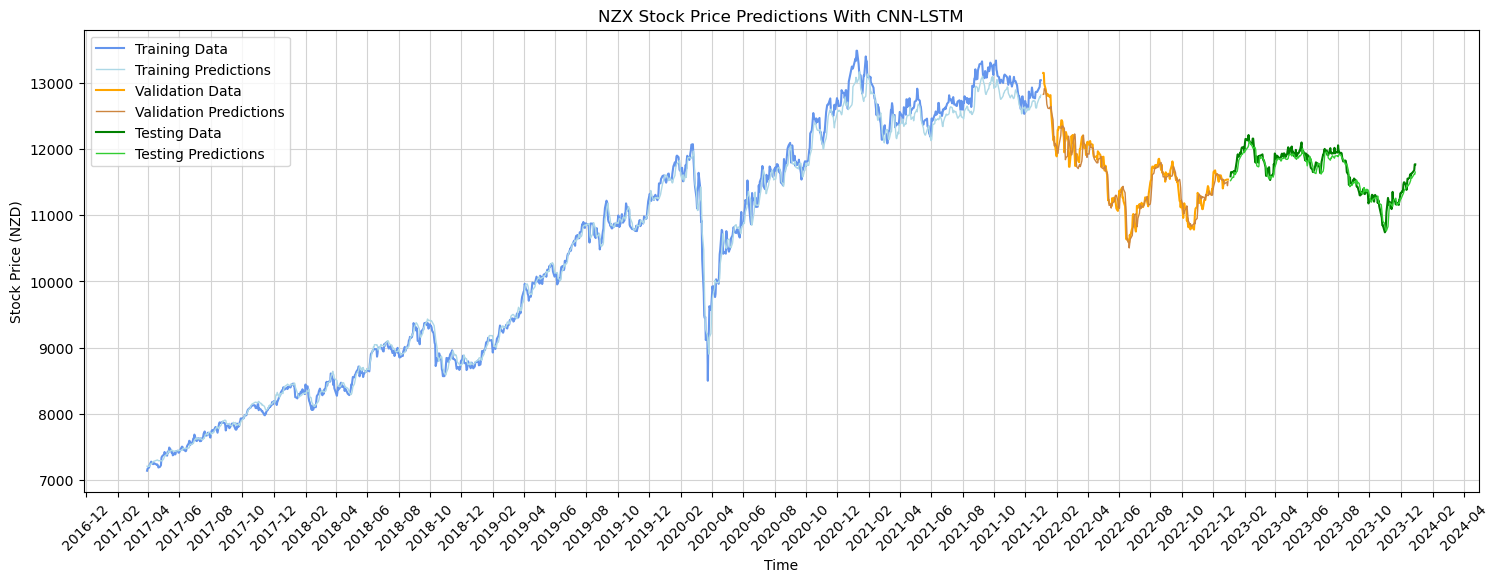

In [22]:
# Plot actual and predicted price
plt.figure(figsize=(18,6))
plt.plot(data_train_dates[time_steps:,], y_train_inv, label="Training Data", color=train_actual_color)
plt.plot(data_train_dates[time_steps:,], y_train_predict_inv, label="Training Predictions", linewidth=1, color=train_predicted_color)

plt.plot(data_validate_dates, y_validate_inv, label="Validation Data", color=validate_actual_color)
plt.plot(data_validate_dates, y_validate_predict_inv, label="Validation Predictions", linewidth=1, color=validate_predicted_color)

plt.plot(data_test_dates, y_test_inv, label="Testing Data", color=test_actual_color)
plt.plot(data_test_dates, y_test_predict_inv, label="Testing Predictions", linewidth=1, color=test_predicted_color)

plt.title("NZX Stock Price Predictions With CNN-LSTM")
plt.xlabel("Time")
plt.ylabel("Stock Price (NZD)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks(rotation=45)
plt.legend()
plt.grid(color="lightgray")
plt.savefig('nzx-cnn-lstm.png')

## GRU-LSTM model

In [23]:
# Build GRU-LSTM model 
#model architecture from https://doi.org/10.1016/j.socl.2020.100009

GRU_LSTM_model = Sequential([
     GRU(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    LSTM(256, activation='relu'),
    Dense(50, activation='relu'),
    Dense(1)
])

GRU_LSTM_model.compile(optimizer='adam', loss='mean_squared_error')

# Checkpoint to save the best model
checkpoint_path = "./best_model.keras"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1, mode='min')

# Train the model
GRU_LSTM_history = GRU_LSTM_model.fit(X_train, y_train, epochs=50, batch_size=32, 
                    validation_data=(X_validate, y_validate), 
                    callbacks=[checkpoint], verbose=1)

# Load the best model
GRU_LSTM_model = load_model(checkpoint_path)

Epoch 1/50


/Users/maythutun/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 0.0768
Epoch 1: val_loss improved from inf to 0.00080, saving model to ./best_model.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - loss: 0.0755 - val_loss: 7.9730e-04
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 7.9033e-04
Epoch 2: val_loss did not improve from 0.00080
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - loss: 7.8557e-04 - val_loss: 8.4297e-04
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 6.0604e-04
Epoch 3: val_loss improved from 0.00080 to 0.00057, saving model to ./best_model.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - loss: 6.0422e-04 - val_loss: 5.7371e-04
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 5.5930e-04
Epoch 4: val_loss did not improve from 0.00057
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - loss: 5.5808e-04 - val_loss: 6.3614e-04
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 4.9323e-04
Epoch 5: val_loss did not improve from 0.00057
38/38 ━━━━━━━━━━━━━━━━

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 9.6926e-05
Epoch 29: val_loss did not improve from 0.00011
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - loss: 9.6943e-05 - val_loss: 1.4649e-04
Epoch 30/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 1.0906e-04
Epoch 30: val_loss did not improve from 0.00011
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - loss: 1.0859e-04 - val_loss: 1.4465e-04
Epoch 31/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 8.1079e-05
Epoch 31: val_loss did not improve from 0.00011
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - loss: 8.1637e-05 - val_loss: 1.4232e-04
Epoch 32/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 6.6097e-05
Epoch 32: val_loss improved from 0.00011 to 0.00008, saving model to ./best_model.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - loss: 6.5866e-05 - val_loss: 8.3877e-05
Epoch 33/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - loss: 6.8713e-05
Epoch 33: val_loss did not improve from 0.00008
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - l

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_3 (GRU)                     │ (None, 60, 50)         │         8,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 256)            │       314,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 50)             │        12,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,007,909 (3.84 MB)

 Trainable params: 335,969 (1.28 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 671,940 (2.56 MB)

/var/folders/vh/j9ngphdx5qj9ztmhtln0kxp40000gn/T/ipykernel_22918/2697948213.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'b-', label='Training loss', color='blue')
/var/folders/vh/j9ngphdx5qj9ztmhtln0kxp40000gn/T/ipykernel_22918/2697948213.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'b-', label='Validation loss', color='orange')


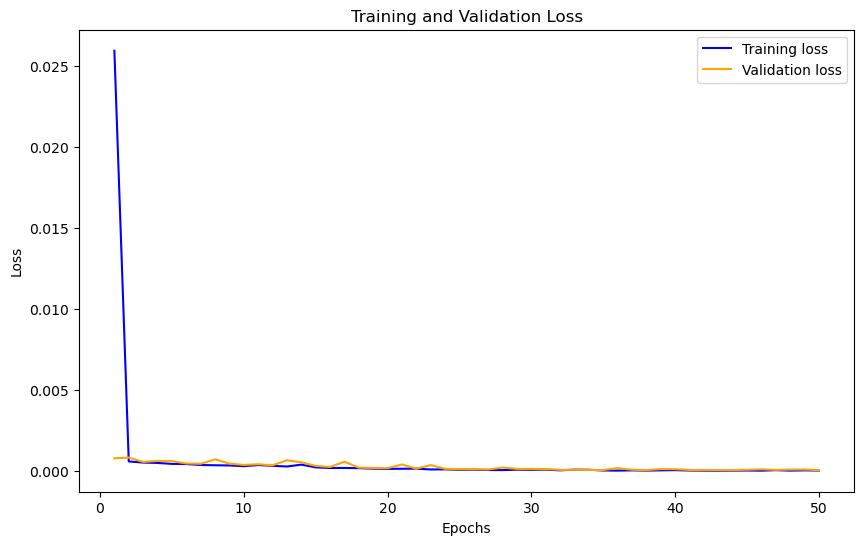

In [24]:
#model summary
GRU_LSTM_model.summary()

# Plot loss curve for CNN

# Extract the loss and val loss
loss = GRU_LSTM_history.history['loss']
val_loss = GRU_LSTM_history.history['val_loss']
epochs = range(1, len(loss) + 1)

# Plot the training and val loss 
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'b-', label='Training loss', color='blue')  
plt.plot(epochs, val_loss, 'b-', label='Validation loss', color='orange') 
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig('loss-grulstm.png')

In [25]:
# Predict stock price for all data splits
y_train_predict = GRU_LSTM_model.predict(X_train)
y_validate_predict = GRU_LSTM_model.predict(X_validate)
y_test_predict = GRU_LSTM_model.predict(X_test)

# Restore actual distribution for predicted prices
y_train_inv = scaler.inverse_transform(np.concatenate((y_train.reshape(-1,1), np.ones((len(y_train.reshape(-1,1)), 5))), axis=1))[:,0]
y_validate_inv = scaler.inverse_transform(np.concatenate((y_validate.reshape(-1,1), np.ones((len(y_validate.reshape(-1,1)), 5))), axis=1))[:,0]
y_test_inv = scaler.inverse_transform(np.concatenate((y_test.reshape(-1,1), np.ones((len(y_test.reshape(-1,1)), 5))), axis=1))[:,0]

y_train_predict_inv = scaler.inverse_transform(np.concatenate((y_train_predict, np.ones((len(y_train_predict), 5))), axis=1))[:,0]
y_validate_predict_inv = scaler.inverse_transform(np.concatenate((y_validate_predict, np.ones((len(y_validate_predict), 5))), axis=1))[:,0]
y_test_predict_inv = scaler.inverse_transform(np.concatenate((y_test_predict, np.ones((len(y_test_predict), 5))), axis=1))[:,0]

# Calculate metrics
rmse_train, r2_train, mape_train = evaluate_model(y_train_inv, y_train_predict_inv)
rmse_validate, r2_validate, mape_validate = evaluate_model(y_validate_inv, y_validate_predict_inv)
rmse_test, r2_test, mape_test = evaluate_model(y_test_inv, y_test_predict_inv)

# Print the results
print("Training Metrics:")
print(f"RMSE: {rmse_train}, R2: {r2_train}, MAPE: {mape_train}%")

print("Validation Metrics:")
print(f"RMSE: {rmse_validate}, R2: {r2_validate}, MAPE: {mape_validate}%")

print("Testing Metrics:")
print(f"RMSE: {rmse_test}, R2: {r2_test}, MAPE: {mape_test}%")

38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Training Metrics:
RMSE: 35.81819127656491, R2: 0.999633152733471, MAPE: 0.20561280551024055%
Validation Metrics:
RMSE: 54.750031641530995, R2: 0.9886183650002839, MAPE: 0.2521285515686884%
Testing Metrics:
RMSE: 37.69120057469469, R2: 0.9860092689772771, MAPE: 0.205325698865614%


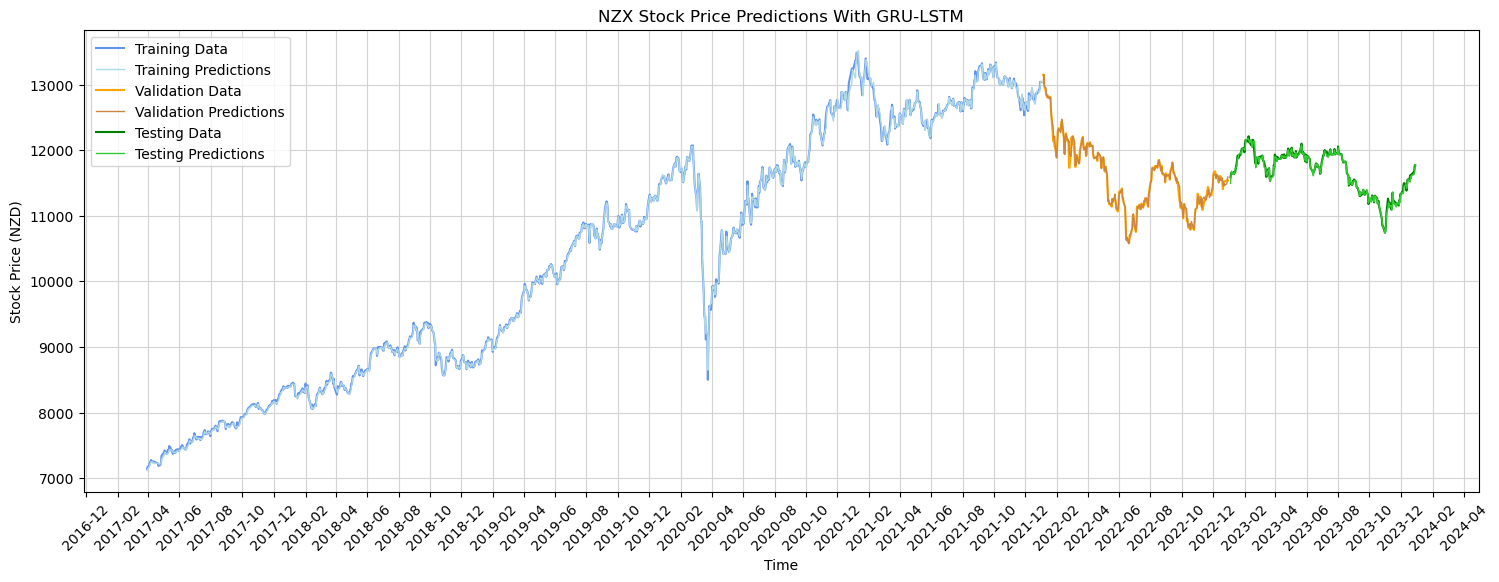

In [26]:
# Plot actual and predicted price
plt.figure(figsize=(18,6))
plt.plot(data_train_dates[time_steps:,], y_train_inv, label="Training Data", color=train_actual_color)
plt.plot(data_train_dates[time_steps:,], y_train_predict_inv, label="Training Predictions", linewidth=1, color=train_predicted_color)

plt.plot(data_validate_dates, y_validate_inv, label="Validation Data", color=validate_actual_color)
plt.plot(data_validate_dates, y_validate_predict_inv, label="Validation Predictions", linewidth=1, color=validate_predicted_color)

plt.plot(data_test_dates, y_test_inv, label="Testing Data", color=test_actual_color)
plt.plot(data_test_dates, y_test_predict_inv, label="Testing Predictions", linewidth=1, color=test_predicted_color)

plt.title("NZX Stock Price Predictions With GRU-LSTM")
plt.xlabel("Time")
plt.ylabel("Stock Price (NZD)")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks(rotation=45)
plt.legend()
plt.grid(color="lightgray")
plt.savefig('nzx-gru-lstm.png')